## Visualizing the Convolutional Neural Network's filters

A way to inspect the filters learned by convnets is to display the visual pattern that each filter is meant to respond to. This can be done with gradient **ascent** in input space : applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a random input image. The resulting input image will be one that the chosen filter is maximally responsive to. 

This process is simple: you’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then you’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value

In [1]:
import cv2
import keras
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
np.random.seed(500)

In [3]:
%matplotlib inline

In [4]:
print(cv2.__version__)
print(keras.__version__)
print(np.__version__)

3.4.1
2.2.4
1.16.3


In [5]:
model = keras.applications.vgg16.VGG16(include_top=True, weights="imagenet")

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [7]:
layer_name = 'block3_conv1'
filter_index = 0

In [8]:
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])  # Loss Tensor of shape 1

To implement gradient ascent, you’ll need the gradient of this loss with respect to the model’s input.
The call to gradients returns a list of tensors (of size 1 in this case). Hence, we take the first element

In [9]:
grads = K.gradients(loss, model.input)[0]

# Normalization Trick
A trick to help the gradient-ascent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average
of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within the same range.

In [10]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  # Gradient Tensor

compute the value of the loss tensor and the gradient tensor, given an input image

In [11]:
iterator = K.function([model.input], [loss, grads])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


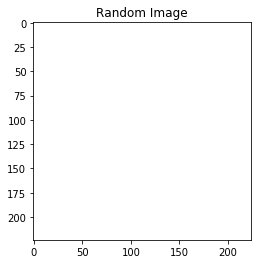

In [12]:
random_image = np.random.random((224, 224, 3)) * 20 + 128
plt.title("Random Image")
plt.imshow(random_image)
plt.show()

In [13]:
random_input_image = np.expand_dims(random_image, axis=0)
print(random_input_image.shape)

(1, 224, 224, 3)


In [14]:
step_size = 1
epochs = 30
for i in tqdm(range(epochs)):
    loss_value, grads_value = iterator([random_input_image])
    random_input_image += grads_value * step_size   # + denotes gradient  ascent

100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


In [15]:
def deprocess_image(x):
    """Utility function to convert a tensor into a valid image
    """
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [16]:
filter_image = deprocess_image(random_input_image[0])

In [17]:
filter_image.shape

(224, 224, 3)

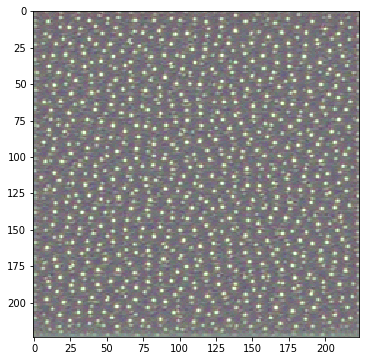

In [18]:
plt.figure(figsize=(6,6))
plt.imshow(filter_image)
plt.show()

Looks like this filter activates when **POLKA DOTS** like patterns are found in the image

In [19]:
def stitch_images(images, margin=5, cols=5):
    """Utility function to stitch images together with a `margin`.
    Args:
        images: The array of 2D images to stitch.
        margin: The black border margin size between images (Default value = 5)
        cols: Max number of image cols. New row is created when number of images exceed the column size.
            (Default value = 5)
    Returns:
        A single numpy image array comprising of input images.
    """
    if len(images) == 0:
        return None

    h, w, c = images[0].shape
    n_rows = int(math.ceil(len(images) / cols))
    n_cols = min(len(images), cols)

    out_w = n_cols * w + (n_cols - 1) * margin
    out_h = n_rows * h + (n_rows - 1) * margin
    stitched_images = np.zeros((out_h, out_w, c), dtype=images[0].dtype)

    for row in range(n_rows):
        for col in range(n_cols):
            img_idx = row * cols + col
            if img_idx >= len(images):
                break

            stitched_images[(h + margin) * row: (h + margin) * row + h,
                            (w + margin) * col: (w + margin) * col + w, :] = images[img_idx]

    return stitched_images

Lets now combine all of the above to a single function. We can use this  function to visualize any layer's any filter

In [20]:
def visualize_single_filter(model, layer_name, filter_index, size=224, step_size=1, epochs=30):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterator = K.function([model.input], [loss, grads])
    random_input_image = np.random.random((1, size, size, 3)) * 20 + 128.
    for i in range(epochs):
        loss_value, grads_value = iterator([random_input_image])
        random_input_image += grads_value * step_size   # + denotes gradient ascent
    img = random_input_image[0]
    return deprocess_image(img)

Let's visualize an array of filters. We will visualize only the top 64 filters in a given layer

In [21]:
layer_name = 'block1_conv1'
filter_nums = 64
filter_images = []
for filter_index in tqdm(range(filter_nums)):
    filter_image = visualize_single_filter(model, layer_name, filter_index)
    filter_images.append(filter_image)

100%|██████████| 64/64 [00:35<00:00,  1.74it/s]


In [22]:
stitched_image = stitch_images(images=filter_images, margin=5, cols=int(np.sqrt(filter_nums)))

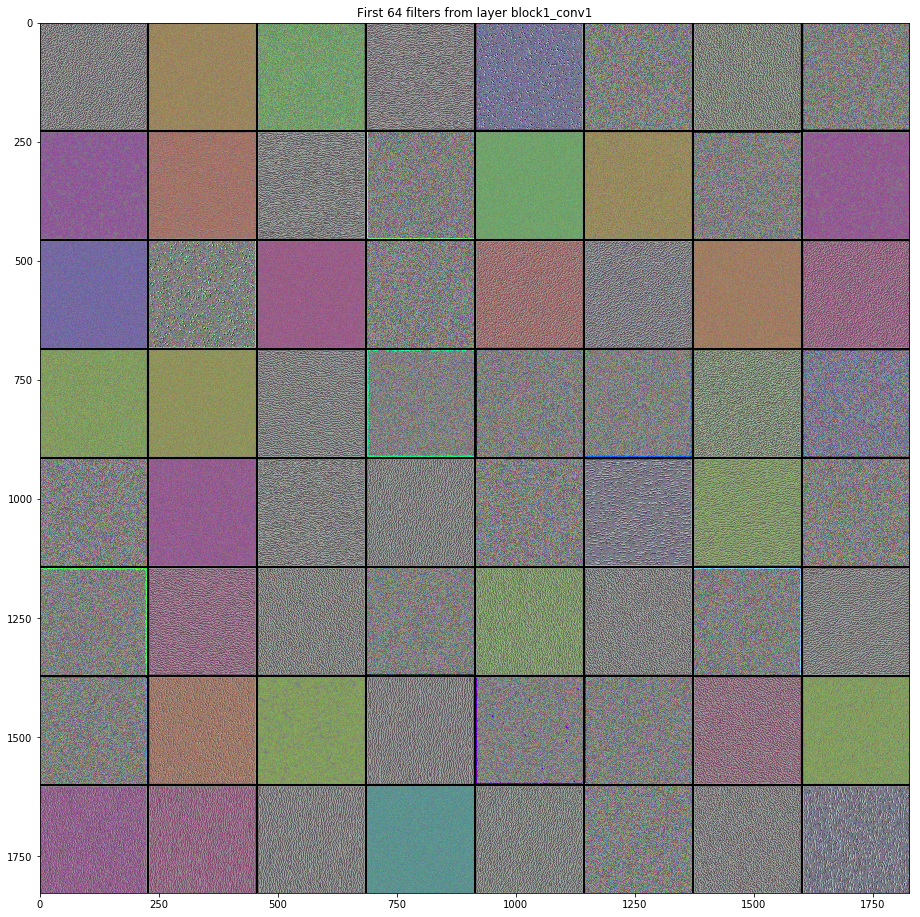

In [23]:
plt.figure(figsize=(16,16))
plt.title("First {} filters from layer {}".format(filter_nums, layer_name))
plt.imshow(stitched_image)
plt.show()

# Inference:

These filter visualizations tell you a lot about how a convolutional neural network sees the world. Each layer in a ConvNet learns a collection of filters such that their inputs can be expressed as a combination of these filters. The filters in these ConvNet layers get increasingly complex and refined as you go higher in the model:

- The filters from the first layer in the model ( block1_conv1 ) encode simple directional edges and colors (or colored edges, in some cases).
- The filters from block2_conv1 encode simple textures made from combinations of edges and colors.
- The filters in higher layers begin to resemble textures found in natural images: feathers, eyes, leaves, and so on.